# Electricity estimations

This builds directly on Matt Rosi's recent work.

This approach uses single-point estimates of the power of appliances along with reported durations of appliance use to get a per-household projection of electricity use.

We see what we expect, that the reported appliance use implies an electricity use that is larger in grid-connected areas.

We have the following data from AE about energy use in one measured household.  We make the assumption that other households use similar appliances.

| Appliance            | kWh per use   | Use         |
| -------------------- | ------------- | ----------- |
| TV + Parabola        | 0.040         | hour        |
| Washing Machine      | 0.03          | kg          |
| Water Pump           | 0.027         | 100 liters  |
| Water Boiler         | 0.090         | liter       |
| Rice Cooker          | 0.380         | kg          |
| Fridge, big          | 2.600         | day         |
| Fridge, small, high  | 2.000         | day         |
| Fridge, small, low   | 1.900         | day         |


Questions:

- What causes the higher spread in the grid estimates?
- Should we be filling nulls with zeros?
- How many results have nulls?

In [1]:
from drs_sentani import get_survey
import pandas as pd
survey = get_survey()
import pysentani as sti
survey['access_type'] = sti.access_type(survey)

# we may want to do this more fine-grained so we know what we are omitting
survey = survey.fillna(0)

$$daily\ energy(kWh) = \left(\frac{use\ times\ per\ week * hours\ per\ use}{7}\right)power(kW)$$

In [2]:
powers = {'TV':0.040, 
          'fridge':0.100, 
          'radio':0.010, 
          'fan':0.050, 
          'rice_cooker':0.350, 
          'lighting':0.050}
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']

for appliance in appliance_list:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(appliance)
    hr_col = 'app_{}_hrs'.format(appliance)
    energy_col = 'daily_{}_energy'.format(appliance)
    weekly_hr_col = 'weekly_{}_hrs'.format(appliance)
    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]    
    survey[energy_col] = survey[weekly_hr_col] / 7 * powers[appliance]
    

Summing individual appliance daily energy to create total daily energy.
Better mathematical representation is needed here. Will need to incorporate sigma notation at some point.

In [3]:
survey['total_daily_energy'] = (survey['daily_TV_energy'] + survey['daily_fridge_energy'] +
                                survey['daily_radio_energy'] + survey['daily_fan_energy'] +
                                survey['daily_rice_cooker_energy'] + survey['daily_lighting_energy'])

Grouping by daily energy totals. The mean of daily energy is taken and applied across village name and access type columns. Daily energy renamed because it now represents the daily energy mean per each household in kWh. Qgrid is used to enable sorting accross data subset.

In [4]:
survey.rename(columns={'total_daily_energy': 'daily_energy_mean'},inplace = True)
subsurvey = survey[['daily_energy_mean','access_type','village_name']]
subsurvey.head()

,daily_energy_mean,access_type,village_name
0,0.180000,no_access,Puai
1,0.131429,no_access,Abar
2,0.120000,no_access,Abar
3,0.137143,no_access,Abar
4,0.300000,no_access,Abar


In [5]:
# the index name is giving me fits here
sort = subsurvey.groupby(['village_name']).mean()
sort['village_name'] = sort.index
sort

,daily_energy_mean,village_name
village_name,,
Abar,217.577981,Abar
Ajau,1.249592,Ajau
Asei,2.637685,Asei
Atamali,0.626163,Atamali
Ayapo,0.495869,Ayapo
Babrongko,11.511855,Babrongko
Burawai,2.061071,Burawai
Donday,0.439686,Donday
Ebunfauw,0.380278,Ebunfauw


In [6]:
sort['access_type'] = sti.access_type(sort)
sort

,daily_energy_mean,village_name,access_type
village_name,,,
Abar,217.577981,Abar,no_access
Ajau,1.249592,Ajau,PLN_grid
Asei,2.637685,Asei,PLN_grid
Atamali,0.626163,Atamali,community_microgrid
Ayapo,0.495869,Ayapo,PLN_microgrid
Babrongko,11.511855,Babrongko,PLN_grid
Burawai,2.061071,Burawai,PLN_grid
Donday,0.439686,Donday,PLN_microgrid
Ebunfauw,0.380278,Ebunfauw,no_access


(0, 20)

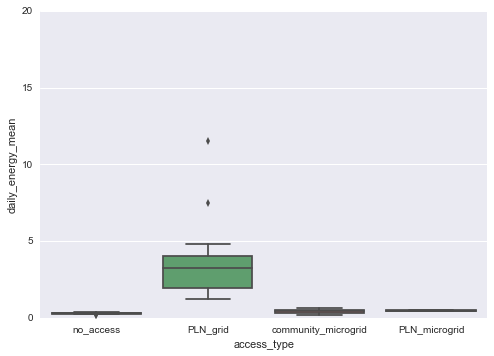

In [7]:
%matplotlib inline
import seaborn as sns

ax = sns.boxplot(data=sort, x='access_type', y='daily_energy_mean')
# note this omits several outliers from view
ax.set_ylim(0, 20)